In [39]:
!pip install medmnist

In [40]:
import medmnist
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import gaussian_filter
from medmnist.dataset import OrganAMNIST
from torchvision import transforms
from numpy.random import RandomState
from torchvision.utils import save_image
from medmnist import INFO
from torchvision.transforms import ToTensor
import torch.utils.data as data

In [41]:
# Image I/O + Preprocessing

def pil_to_tensor(img):
    return transforms.ToTensor()(img)

def tensor_to_np(img_tensor):
    return img_tensor.squeeze(0).numpy()

In [42]:
# Distortion Classes

class AdjustContrast:
    def __init__(self, contrast_level):
        self.contrast_level = contrast_level
    def __call__(self, img):
        arr = np.array(img).astype(np.float32) / 255.0
        arr = np.clip((1 - self.contrast_level) / 2 + self.contrast_level * arr, 0, 1)
        return torch.tensor(arr).unsqueeze(0)

class GaussianNoise:
    def __init__(self, std=0.1):
        self.std = std
    def __call__(self, img):
        tensor = transforms.ToTensor()(img)
        noise = torch.randn_like(tensor) * self.std
        return torch.clamp(tensor + noise, 0, 1)

class SaltPepperNoise:
    def __init__(self, p=0.1):
        self.p = p
    def __call__(self, img):
        tensor = transforms.ToTensor()(img)
        rand = torch.rand_like(tensor)
        tensor[rand < self.p / 2] = 0.0
        tensor[rand > 1 - self.p / 2] = 1.0
        return tensor

class UniformNoise:
    def __init__(self, width=0.2, seed=42):
        self.width = width
        self.rng = RandomState(seed)
    def __call__(self, img):
        arr = np.array(img).astype(np.float32) / 255.0
        noise = self.rng.uniform(-self.width, self.width, size=arr.shape)
        arr = np.clip(arr + noise, 0, 1)
        return torch.tensor(arr).unsqueeze(0)

class GaussianBlur:
    def __init__(self, kernel_size=3):
        self.kernel_size = kernel_size
    def __call__(self, img):
        return transforms.Compose([
            transforms.GaussianBlur(kernel_size=self.kernel_size),
            transforms.ToTensor()
        ])(img)

class ColorJitter:
    def __init__(self, brightness=0.4, contrast=0.4):
        self.transform = transforms.Compose([
            transforms.ColorJitter(brightness=brightness, contrast=contrast),
            transforms.ToTensor()
        ])
    def __call__(self, img):
        return self.transform(img)

class Rotate90:
    def __call__(self, img):
        arr = np.array(img)
        rotated = np.rot90(arr, k=1)
        return torch.tensor(rotated.astype(np.float32) / 255.0).unsqueeze(0)

class Rotate180:
    def __call__(self, img):
        arr = np.array(img)
        rotated = np.rot90(arr, k=2)
        return torch.tensor(rotated.astype(np.float32) / 255.0).unsqueeze(0)

class Rotate270:
    def __call__(self, img):
        arr = np.array(img)
        rotated = np.rot90(arr, k=3)
        return torch.tensor(rotated.astype(np.float32) / 255.0).unsqueeze(0)

In [43]:
# Visualization

def show_distortion_comparison(dataset, transforms_dict, indices=[]):
    """
    Show the original image and its distortions side by side.

    Parameters:
    - dataset: OrganMNIST dataset (PIL images, transform=None)
    - transforms_dict: dict of {name: transform}
    - indices: list of dataset indices to save
    """
    num_imgs = len(indices)
    num_transforms = len(transforms_dict)

    plt.figure(figsize=(4 * (num_transforms + 1), 3 * num_imgs))

    for row, idx in enumerate(indices):
        raw_img, label = dataset[idx]
        raw_np = tensor_to_np(pil_to_tensor(raw_img))

        # Column 0: Original
        plt.subplot(num_imgs, num_transforms + 1, row * (num_transforms + 1) + 1)
        plt.imshow(raw_np, cmap='gray')
        plt.title(f"Original\nImage: {idx}\nLabel: {label}")
        plt.axis('off')

        # Distorted columns
        for col, (name, transform) in enumerate(transforms_dict.items(), start=1):
            distorted = transform(raw_img)
            distorted_np = tensor_to_np(distorted)
            plt.subplot(num_imgs, num_transforms + 1, row * (num_transforms + 1) + col + 1)
            plt.imshow(distorted_np, cmap='gray')
            plt.title(f"{name}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

In [44]:
# Save images in npz format

def save_distorted_subset_to_npz(dataset, split_name, transforms_dict, indices, output_root):
    """
    Save only a subset of images from a dataset (original + distortions) into .npz files.

    Parameters:
    - dataset: OrganMNIST dataset (PIL images, transform=None)
    - split_name: "train", "val", or "test"
    - transforms_dict: dict of {name: transform}
    - indices: list of dataset indices to save
    - output_root: folder to save npz files
    """
    output_dir = os.path.join(output_root, f"{split_name}_subset")
    os.makedirs(output_dir, exist_ok=True)

    for idx in indices:
        raw_img, label = dataset[idx]
        base_key = f"image{idx}_label{label}"

        img_dict = {
            "original": pil_to_tensor(raw_img).squeeze(0).numpy()
        }

        for name, transform in transforms_dict.items():
            transformed = transform(raw_img).squeeze(0).numpy()
            key = name.replace(" ", "_").replace("°", "deg")
            img_dict[key] = transformed

        img_dict["label"] = label

        file_path = os.path.join(output_dir, f"{base_key}.npz")
        np.savez_compressed(file_path, **img_dict)

    print(f"\n✅ Saved {len(indices)} subset images to {output_dir}")


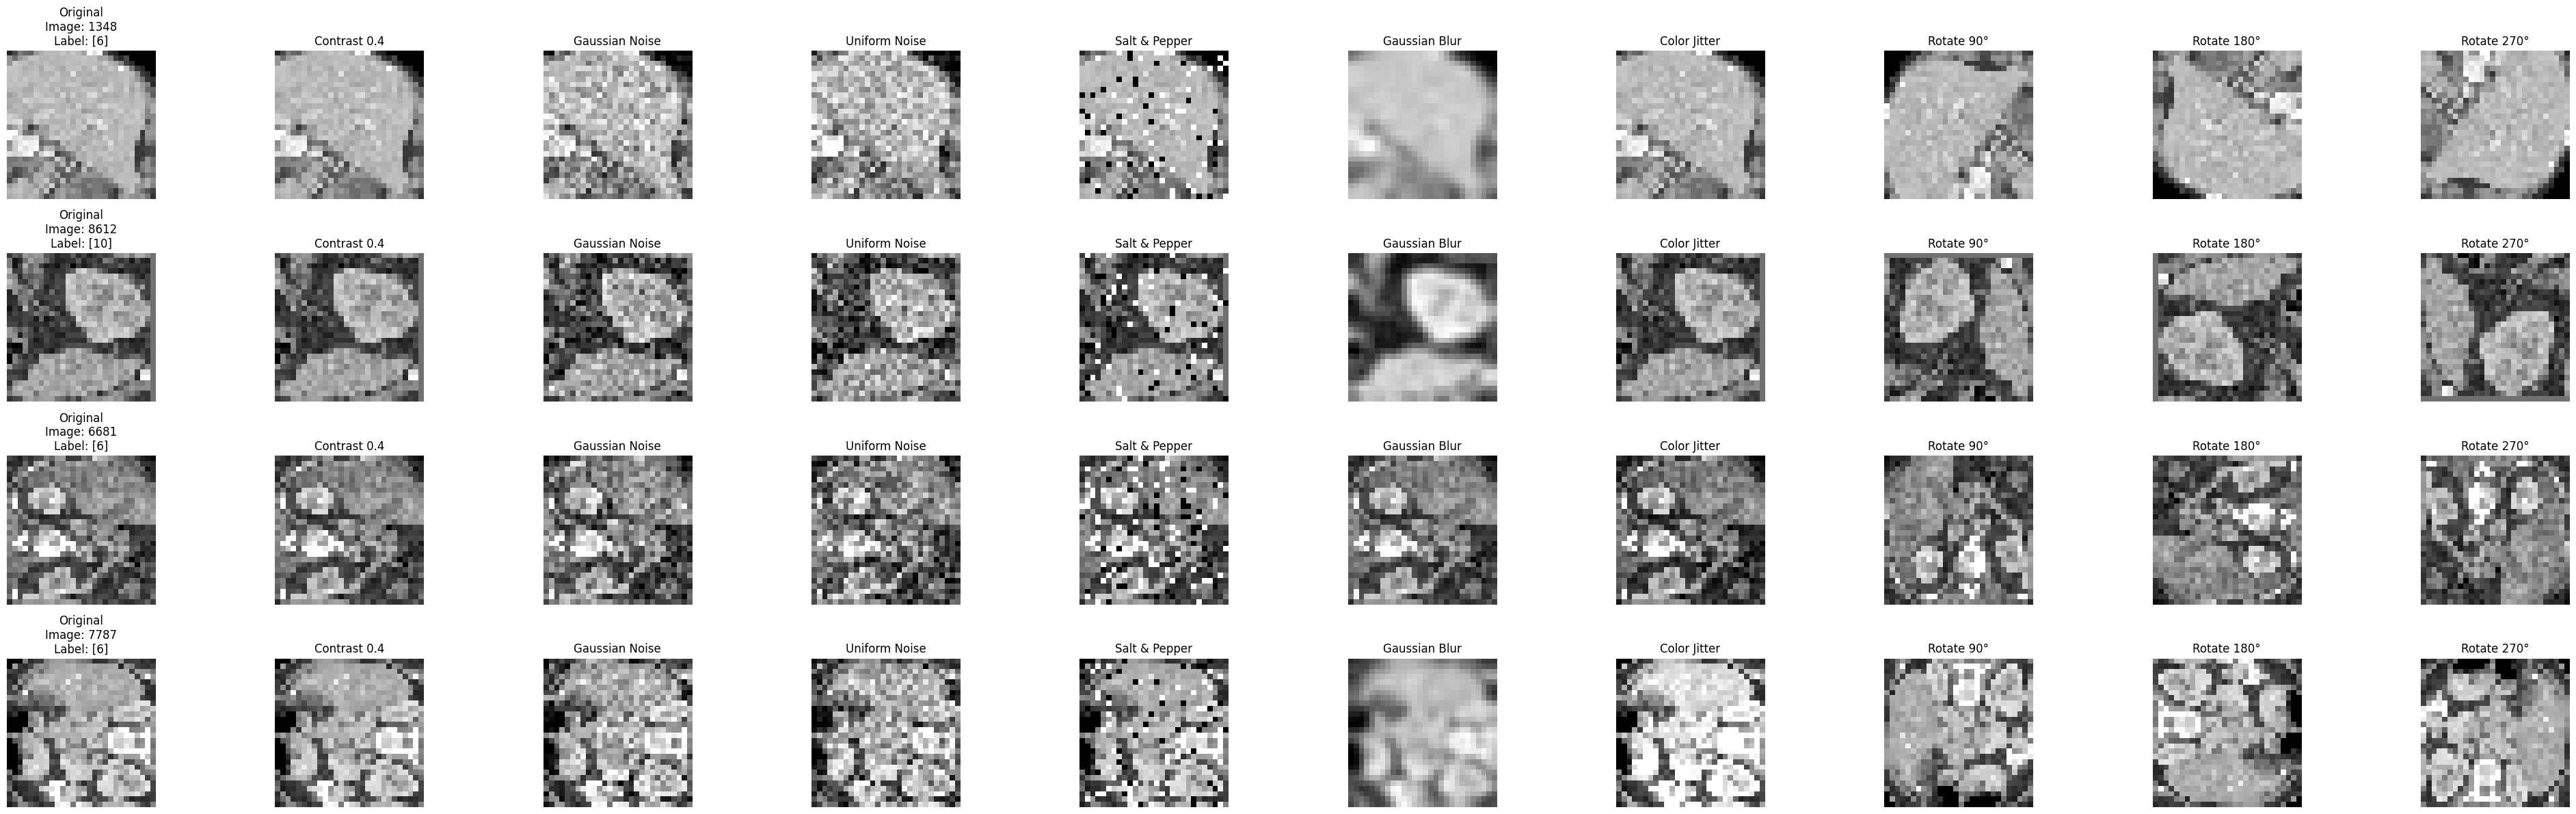

In [45]:

# Load PIL image version (no transform)
train_raw = OrganAMNIST(split='train', transform=None, download=True)
val_raw = OrganAMNIST(split='val', transform=None, download=True)
test_raw = OrganAMNIST(split='test', transform=None, download=True)

distortions = {
        "Contrast 0.4": AdjustContrast(contrast_level=0.4),
        "Gaussian Noise": GaussianNoise(std=0.1),
        "Uniform Noise": UniformNoise(width=0.2),
        "Salt & Pepper": SaltPepperNoise(p=0.1),
        "Gaussian Blur": GaussianBlur(kernel_size=3),
        "Color Jitter": ColorJitter(brightness=0.5, contrast=0.4),
        "Rotate 90°": Rotate90(),
        "Rotate 180°": Rotate180(),
        "Rotate 270°": Rotate270()
    }

# Random indices
train_subset_indices = np.random.choice(10000, 4)
test_subset_indices = np.random.choice(10000, 4)
val_subset_indices = np.random.choice(10000, 4)

# Display the images
show_distortion_comparison(train_raw, distortions, indices=train_subset_indices)


In [46]:
# Save distorted training images

save_distorted_subset_to_npz(
    dataset=train_raw,
    split_name="train",
    transforms_dict=distortions,
    indices=train_subset_indices,
    output_root="/content/distorted_npz"
)


✅ Saved 4 subset images to /content/distorted_npz/train_subset


In [47]:
# Save distorted testing images

save_distorted_subset_to_npz(
    dataset=test_raw,
    split_name="test",
    transforms_dict=distortions,
    indices=test_subset_indices,
    output_root="/content/distorted_npz"
)


✅ Saved 4 subset images to /content/distorted_npz/test_subset


In [48]:
!ls /content/distorted_npz

test_subset  train_subset


In [58]:
!ls /content/distorted_npz/train_subset

'image1348_label[6].npz'  'image7787_label[6].npz'
'image6681_label[6].npz'  'image8612_label[10].npz'


In [54]:
!ls /content/distorted_npz/test_subset

'image1954_label[10].npz'  'image6833_label[8].npz'
'image3442_label[1].npz'   'image8182_label[4].npz'


In [34]:
! rm /content/distorted_npz/train_subset/*

In [35]:
! rm /content/distorted_npz/test_subset/*

In [55]:
# Zip the folder
!zip -r /content/distorted_subset.zip /content/distorted_npz

updating: content/distorted_npz/ (stored 0%)
updating: content/distorted_npz/test_subset/ (stored 0%)
updating: content/distorted_npz/train_subset/ (stored 0%)
updating: content/distorted_npz/test_subset/image6833_label[8].npz (deflated 4%)
updating: content/distorted_npz/test_subset/image1954_label[10].npz (deflated 4%)
updating: content/distorted_npz/test_subset/image8182_label[4].npz (deflated 4%)
updating: content/distorted_npz/test_subset/image3442_label[1].npz (deflated 5%)
updating: content/distorted_npz/train_subset/image1348_label[6].npz (deflated 4%)
updating: content/distorted_npz/train_subset/image7787_label[6].npz (deflated 4%)
updating: content/distorted_npz/train_subset/image8612_label[10].npz (deflated 4%)
updating: content/distorted_npz/train_subset/image6681_label[6].npz (deflated 3%)


In [56]:
# Download the zipped folder

from google.colab import files
files.download('/content/distorted_subset.zip')
print("✅ Zip file downloaded.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Zip file downloaded.


In [59]:
npz_path = "/content/distorted_npz/train_subset/image1348_label[6].npz"
distorted_images = np.load(npz_path)

print("Available keys in the file:", distorted_images.files)

Available keys in the file: ['original', 'Contrast_0.4', 'Gaussian_Noise', 'Uniform_Noise', 'Salt_&_Pepper', 'Gaussian_Blur', 'Color_Jitter', 'Rotate_90deg', 'Rotate_180deg', 'Rotate_270deg', 'label']


In [60]:
def show_distorted_image_from_npz(npz_path, distortion_key=""):
    """
    Display a specific distorted image from a .npz file.

    Parameters:
    - npz_path: str, path to the .npz file
    - distortion_key: str, key for the distortion to display (e.g., 'Gaussian_Noise')
    """
    data = np.load(npz_path)

    if distortion_key not in data:
        print(f"❌ Distortion '{distortion_key}' not found in file.")
        print("Available keys:", data.files)
        return

    image = data[distortion_key]

    plt.imshow(image, cmap='gray')
    plt.title(distortion_key)
    plt.axis('off')
    plt.show()

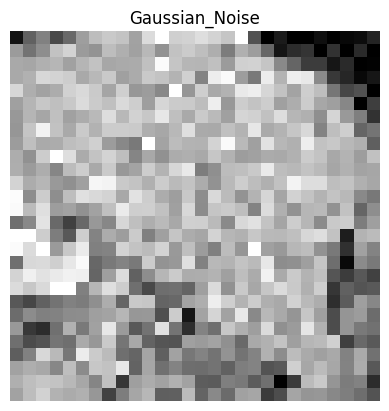

In [61]:
# View an image with a specific distortion type

show_distorted_image_from_npz(
    npz_path="/content/distorted_npz/train_subset/image1348_label[6].npz",
    distortion_key="Gaussian_Noise"
)

In [20]:
def show_all_images_from_npz(npz_path):
    """
    Display all image arrays (except 'label') from a .npz file.

    Parameters:
    - npz_path: str, path to the .npz file
    """
    data = np.load(npz_path)

    for key in data.files:
        if key != "label":
            plt.imshow(data[key], cmap='gray')
            plt.title(key)
            plt.axis('off')
            plt.show()

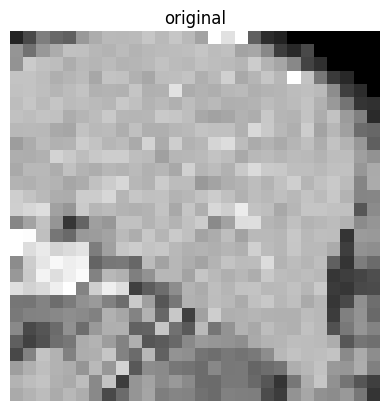

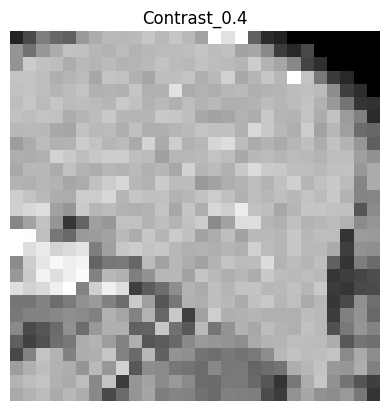

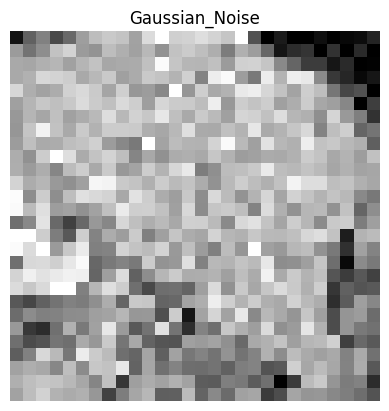

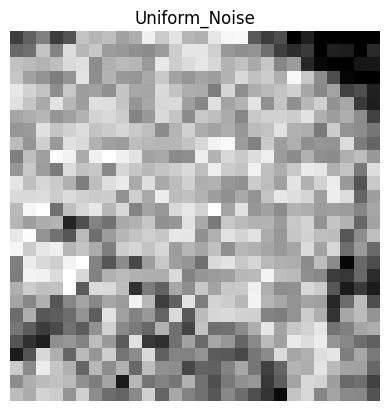

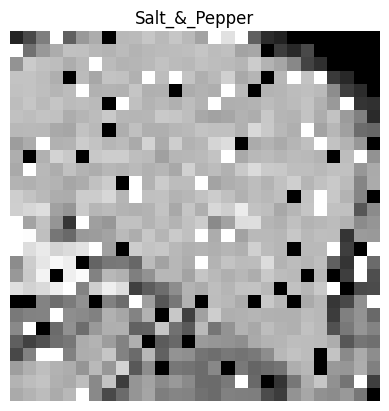

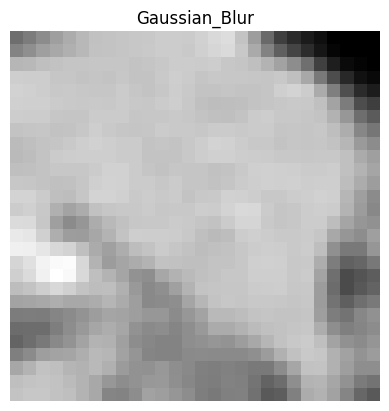

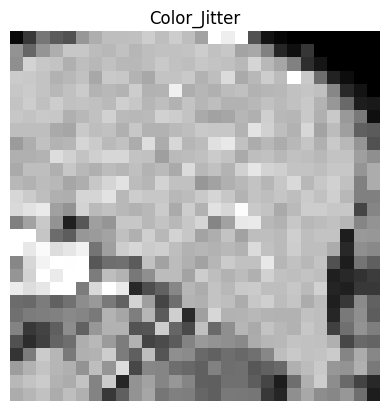

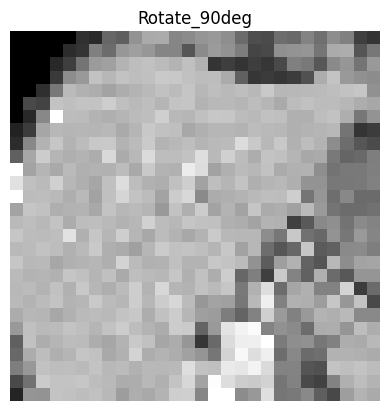

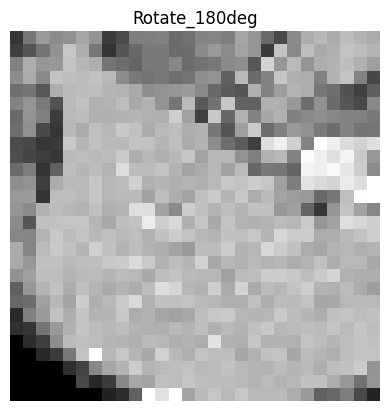

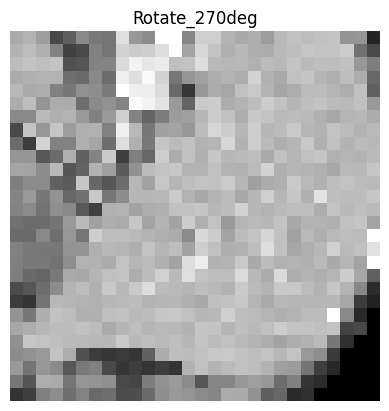

In [62]:
# View all the images in a npz file

show_all_images_from_npz("/content/distorted_npz/train_subset/image1348_label[6].npz")